# Implement the Decision Tree Algorithm

### Import Required Libraries

In [1]:
# import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

### Entropy

In [2]:
# Define Entropy
def entropy(data):
    classes, noexamples = np.unique(data, return_counts=True)
    probabilities = noexamples / noexamples.sum()
    return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

### Gini Index

In [3]:
# Define Gini Index
def gini(data):
    classes, noexamples = np.unique(data, return_counts=True)
    probabilities = noexamples / noexamples.sum()
    return 1 - np.sum(probabilities**2)

### Information Gain

In [4]:
# Define Information Gain as the difference between entropy/gini of the parent and weight average of the entropy/gini of the
# child nodes after split
def information_gain(data, data_left, data_right, criterion="gini_index"):
    if criterion == "standard_information_gain":
        parentimpurity = entropy(data)
    elif criterion == "gini_index":
        parentimpurity = gini(data)
    n = len(data)
    n_left = len(data_left)
    n_right = len(data_right)
    if criterion == "standard_information_gain":
        weightedimpurity = (n_left / n) * entropy(data_left) + (n_right / n) * entropy(data_right)
    elif criterion == "gini_index":
        weightedimpurity = (n_left / n) * gini(data_left) + (n_right / n) * gini(data_right)
    return parentimpurity - weightedimpurity

### Split data into left and right subsets

In [5]:
# split the data after selecting the attribute
def split_dataset(features, target, feature_ind, threshold):
    left_indices = np.where(features[:, feature_ind] <= threshold)[0]
    right_indices = np.where(features[:, feature_ind] > threshold)[0]
    return features[left_indices], features[right_indices], target[left_indices], target[right_indices]

### Select the best split based on the given criteria

In [6]:
# find the attribute that gives the best split
def best_split(features, target, criterion="gini_index"):
    best_feature = None
    best_threshold = None
    best_gain = -1
    n_features = features.shape[1]
    for feature_index in range(n_features):
        thresholds = np.unique(features[:, feature_index])
        for threshold in thresholds:
            features_left, features_right, target_left, target_right = split_dataset(features, target, feature_index, threshold)
            # check if obtained information gain is greater than existing gain
            if len(target_left) > 0 and len(target_right) > 0:
                gain = information_gain(target, target_left, target_right, criterion=criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
    return best_feature, best_threshold, best_gain

### Calculate statistical chi2 value to test for pruning, prune(ON or OFF) is a hyperparameter

In [7]:
# calculate the statistical chi2 value
def chi2_statistic(data, data_left, data_right):
        data_flat = data.reshape(-1).tolist()
        data_left_flat = data_left.reshape(-1).tolist()
        data_right_flat = data_right.reshape(-1).tolist()
        data_counts = Counter(data_flat)
        data_left_counts = Counter(data_left_flat)
        data_right_counts = Counter(data_right_flat)
        labels = list(data_counts.keys())
        n_labels = len(labels)
        observed_values = np.zeros((2, n_labels))
        for i, label in enumerate(labels):
            observed_values[0, i] = data_left_counts.get(label, 0)
            observed_values[1, i] = data_right_counts.get(label, 0)
        total_left = np.sum(observed_values[0, :])
        total_right = np.sum(observed_values[1, :])
        total = total_left + total_right
        expected_values = np.zeros_like(observed_values)
        for i in range(n_labels):
            expected_values[0, i] = total_left * np.sum(observed_values[:, i]) / total
            expected_values[1, i] = total_right * np.sum(observed_values[:, i]) / total
        chi_square = np.sum((observed_values - expected_values) ** 2 / expected_values)
        dof = (n_labels - 1)
        return chi_square, dof

### DecisionTree class with the methods fit, build_tree, predict, predict_sample, export_graphviz

In [8]:
import numpy as np
from collections import Counter

class DecisionTree:

    def __init__(self, criterion="gini_index", max_depth=None, significance_level = 0.05, prune = "OFF"):
        self.criterion = criterion
        self.max_depth = max_depth
        self.decision_tree = None
        self.significance_level = significance_level
        self.prune = prune

    def build_tree(self, features, target, depth=0):
        n_examples, n_features = features.shape
        labels = np.unique(target)

        if len(labels) == 1:
            return labels[0]

        if self.max_depth is not None and depth >= self.max_depth:
            return np.bincount(target).argmax()

        feature, threshold, gain = best_split(features, target, self.criterion)
        
        if gain == 0:
            return np.bincount(target).argmax()

        features_left, features_right, target_left, target_right = split_dataset(features, target, feature, threshold)

        if self.prune == "ON":
            chi2_statistical, dof = chi2_statistic(target, target_left, target_right)
            # check the chi square value obtained degrees of freedom and level of significance
            chi2_critical = st.chi2.ppf(1 - self.significance_level, dof)
            if chi2_statistical < chi2_critical:
                return np.bincount(target).argmax()
        
        left_subtree = self.build_tree(features_left, target_left, depth + 1)
        right_subtree = self.build_tree(features_right, target_right, depth + 1)
        return {"feature": feature, "threshold": threshold, "left": left_subtree, "right": right_subtree}

    # fit or train the decision tree 
    def fit(self, features, target):
        self.decision_tree = self.build_tree(features, target)

    # Visualization of the decision tree
    def export_graphviz(self, feature_names, tree = None):
        if tree is None:
            tree = self.decision_tree
        
        def recurse(node, dot=None, parent=None, edge_label=None):
            if dot is None:
                dot = graphviz.Digraph()
            if isinstance(node, dict):
                node_id = f'node_{id(node)}'
                label = f'Feature {feature_names[node["feature"]]} <= {node["threshold"]}'
                dot.node(node_id, label)
                if parent is not None:
                    dot.edge(parent, node_id, label=edge_label)
                recurse(node['left'], dot, node_id, 'True')
                recurse(node['right'], dot, node_id, 'False')
            else:
                leaf_id = f'leaf_{id(node)}'
                dot.node(leaf_id, f'Class: {node}', shape='box')
                if parent is not None:
                    dot.edge(parent, leaf_id, label=edge_label)
            return dot
        dot = recurse(tree)
        return dot

    def predict_sample(self, data, tree):
        if isinstance(tree, dict):
            feature = tree["feature"]
            threshold = tree["threshold"]
            if data[feature] <= threshold:
                return self.predict_sample(data, tree["left"])
            else:
                return self.predict_sample(data, tree["right"])
        else:
            return tree

    def predict(self, X):
        return [self.predict_sample(x, self.decision_tree) for x in X]

# Use the decision tree to develop a model for WDBC dataset

## Exploratory Data Analysis and pre-processing

In [9]:
# read the data from .csv files through pandas as dataframe
# read train, dev and test data
data_train = pd.read_csv('wdbc_train_normalized.csv')
data_dev = pd.read_csv('wdbc_dev_normalized.csv')
data_test = pd.read_csv('wdbc_test_normalized.csv')

In [10]:
# shape of the data - number of examples and features
data_train.shape

(341, 31)

In [11]:
type(data_train)

pandas.core.frame.DataFrame

In [12]:
# Splitting the data into features and target 
# this splitting converts pandas dataframe to a numpy array
X_train = data_train.iloc[:, :-1].values  # Features
y_train = data_train.iloc[:, -1].values   # Target

X_dev = data_dev.iloc[:, :-1].values      # Dev features
y_dev = data_dev.iloc[:, -1].values       # Dev target

X_test = data_test.iloc[:, :-1].values    # Test features
y_test = data_test.iloc[:, -1].values     # Test target

In [13]:
type(y_train)

numpy.ndarray

In [14]:
y_train

array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B',
       'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B',
       'B', 'B', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'B',
       'B', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'M', 'B',
       'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B',
       'M', 'M', 'B', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B

In [15]:
# Here M- Malignant is considered positive and Bening is considered negative, so I map M-1, B-0
y_train_mapped = np.where(y_train == 'B', 0, 1)
y_test_mapped = np.where(y_test == 'B', 0, 1)
y_dev_mapped = np.where(y_dev == 'B', 0, 1)

In [16]:
y_train_mapped

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,

In [17]:
!pip install missingno

<Axes: >

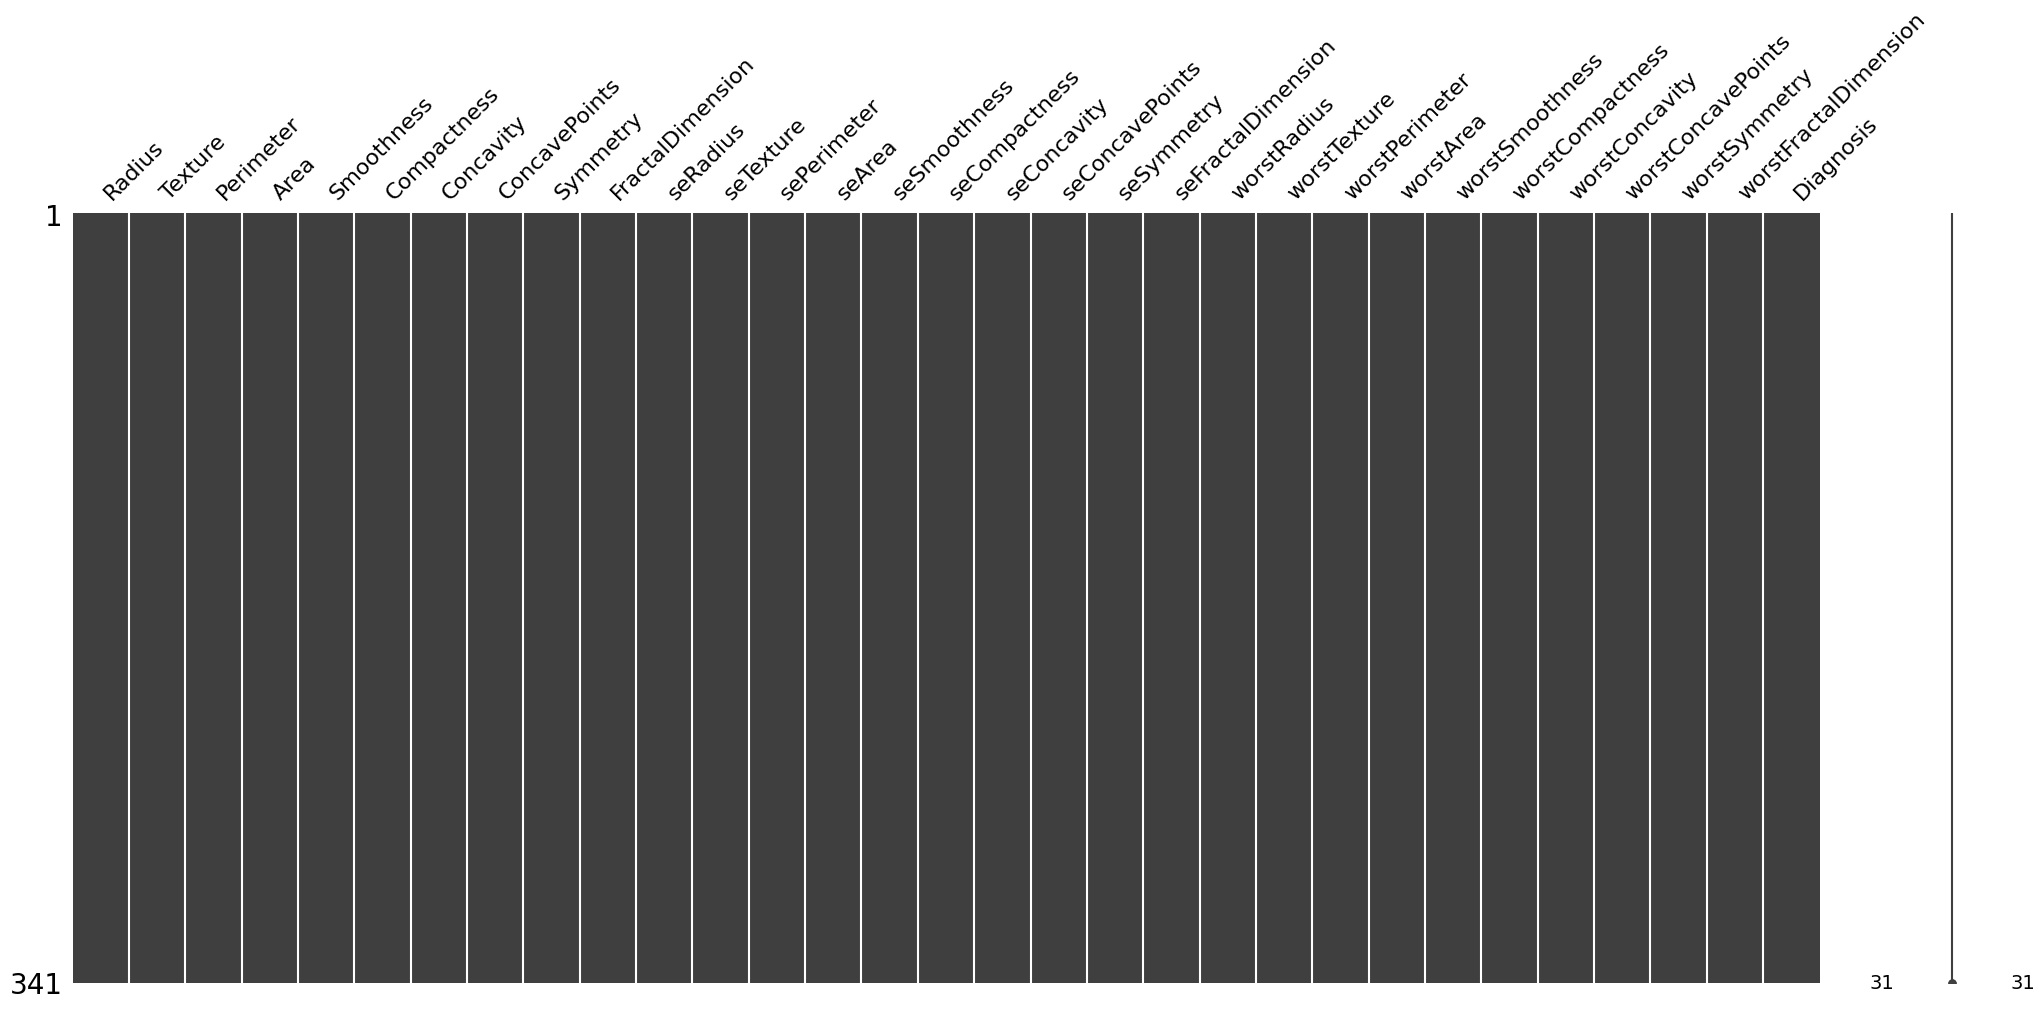

In [18]:
# checking for missing values visually
import missingno as msn
# checking for missing values in train data
msn.matrix(data_train)

<Axes: >

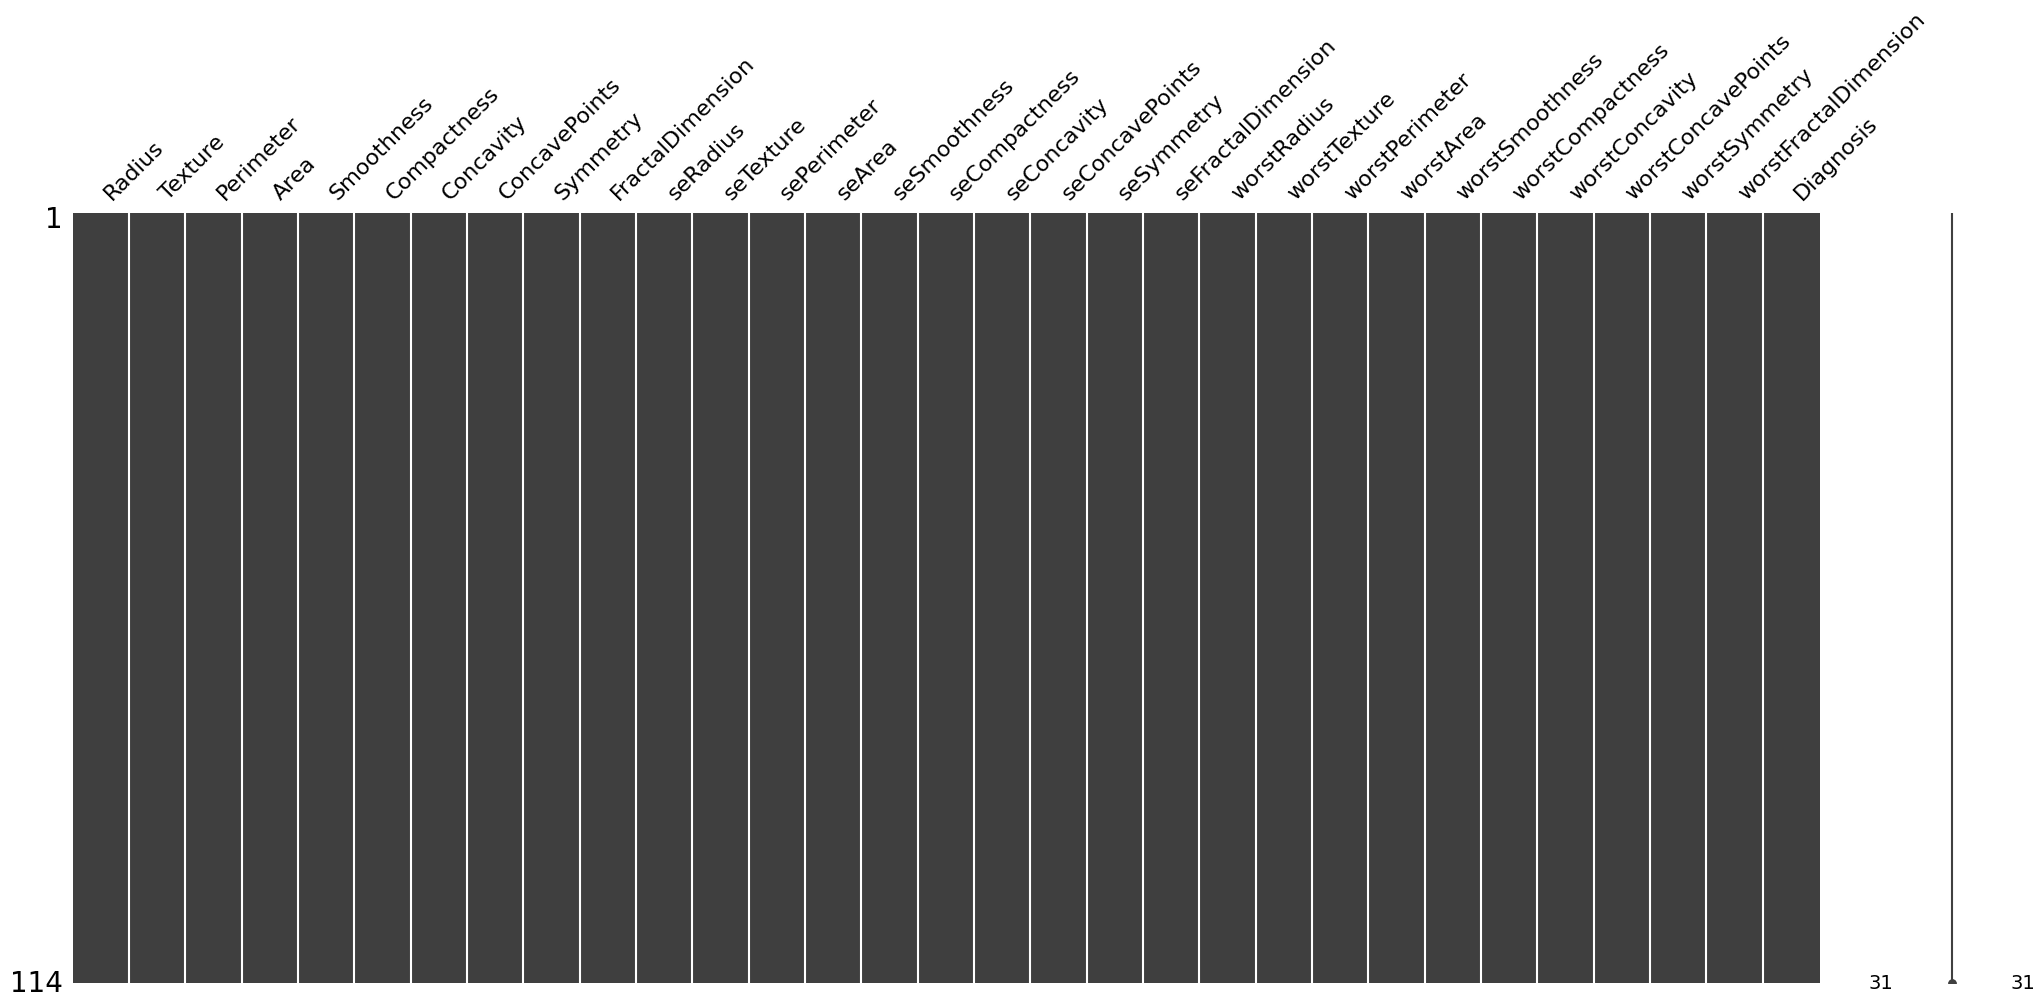

In [19]:
# check for missing values in the dev data
msn.matrix(data_dev)

<Axes: >

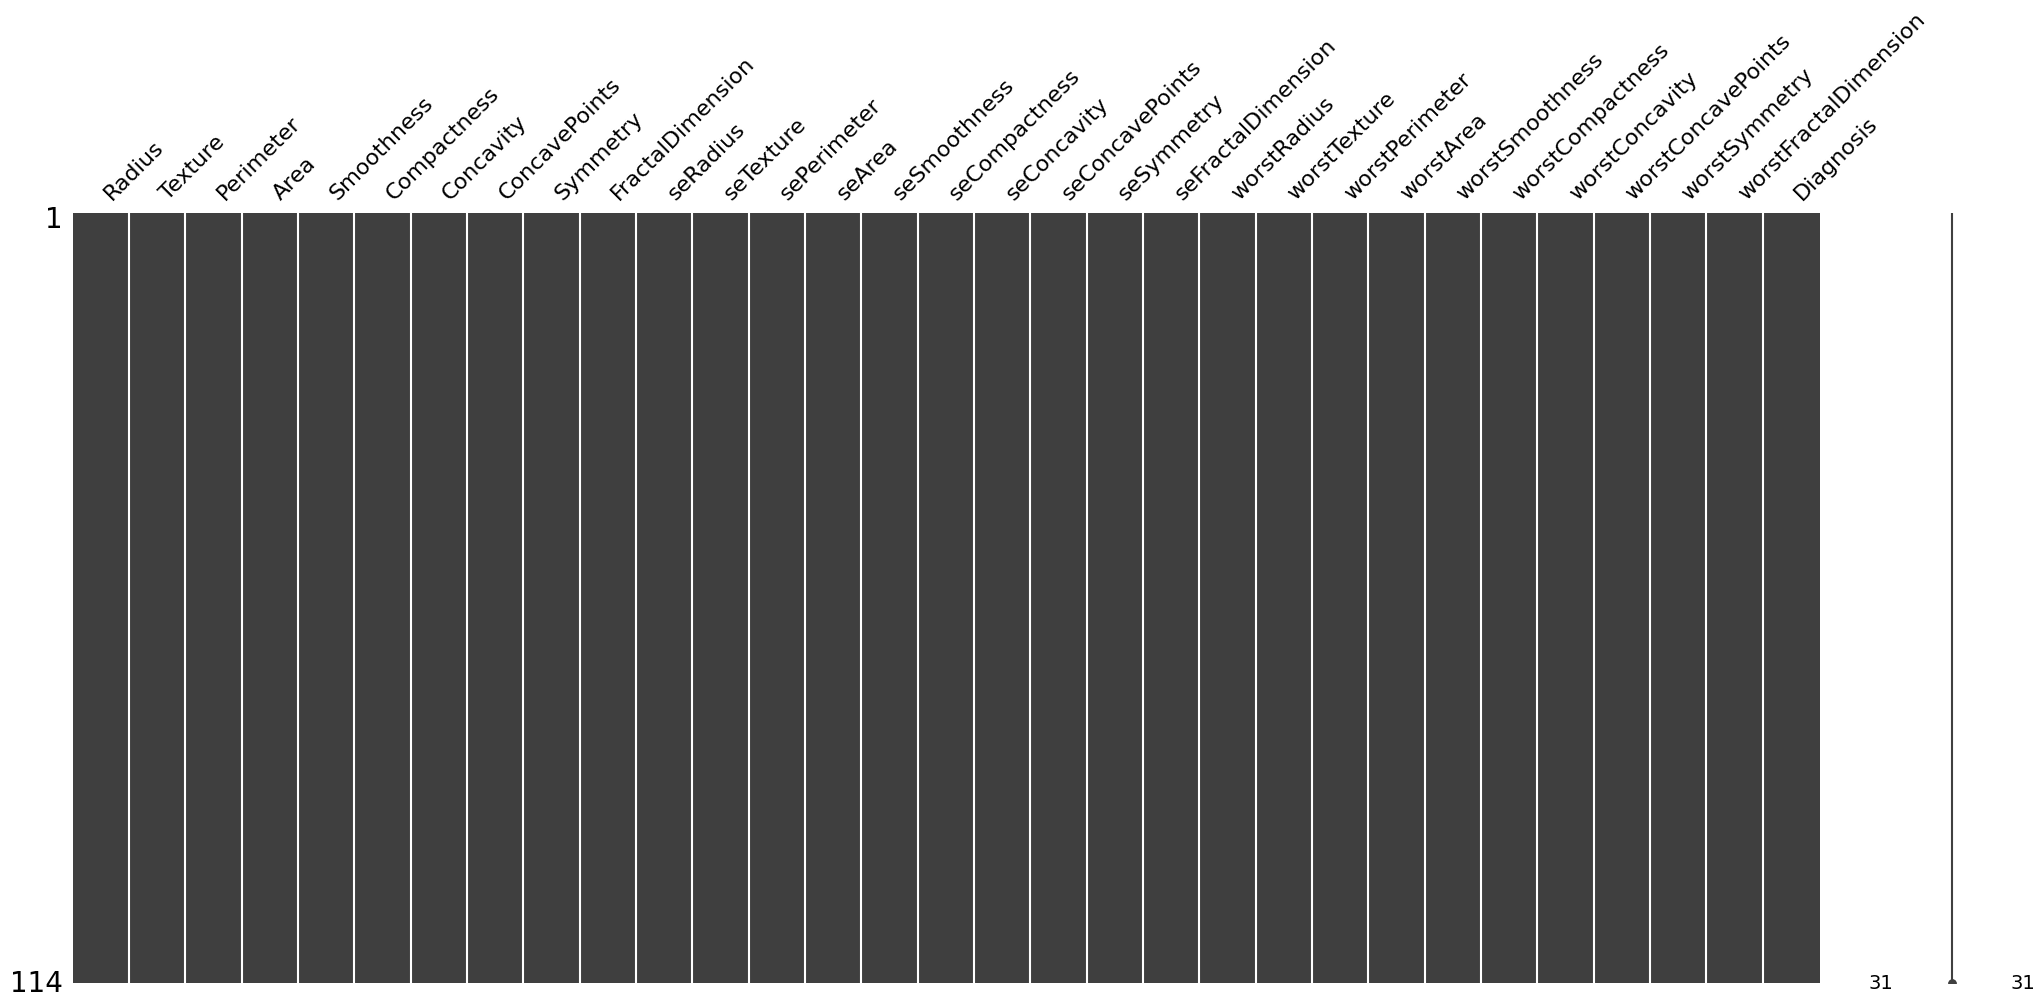

In [20]:
# check for missing values in the test data
msn.matrix(data_test)

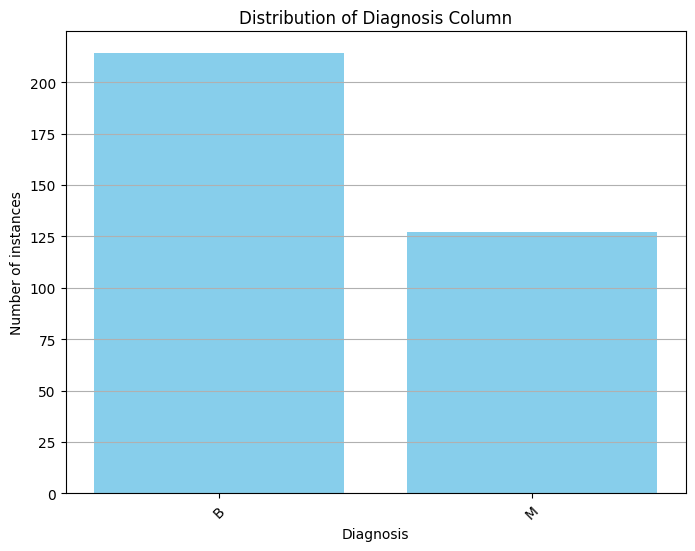

In [21]:
class_counts = data_train['Diagnosis'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index.astype(str), class_counts.values, color='skyblue')
plt.xlabel('Diagnosis')
plt.ylabel('Number of instances')
plt.title('Distribution of Diagnosis Column')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Interpretation: there is quite significant imbalance in the number of instances of both the classes. This might affect the accuracy of the decision tree or there is a chance of model being generalized more to Benign class 

## Train the decision Tree with no pruning

In [22]:
# train the decision tree classifier
def train(X_train, y_train, criterion="gini_index", max_depth=None, significance_level = 0.05, prune = "OFF"):
    tree = DecisionTree(criterion=criterion, max_depth=max_depth, significance_level = significance_level, prune = prune)
    tree.fit(X_train, y_train)
    return tree

In [23]:
# Train the model using train data and default hyperparameter values
# criterion = gini_index, prune = OFF, chi_square_threshold = 0.05, prune = "OFF", max_depth = None(no limit)
tree = train(X_train = X_train, y_train = y_train_mapped, criterion="gini_index", max_depth=3, significance_level = None, prune = "OFF")

## Define performance metrics

Pre-requisite: Iam considering "Malignant" as positive here since positive represents presence of cancer cells. so 0 - negative, 1 - positive

In [24]:
#accuracy
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

#precision
def precision_score(y_true, y_pred):
    tp = 0
    fp = 0
    for tl, pl in zip(y_true, y_pred):
        # increment true positive if predicted label and true labels are zeroes. Here, positive label = 'M' or 1
        if pl == 1:
            if tl == 1:
                tp += 1
            # if predicted label is 0, but true label is 1
            else:
                fp += 1
    if (tp + fp) == 0:
        return 0.0  # Handle division by zero if no positives are predicted
    precision = tp / (tp + fp)
    return precision
    
#recall
def recall_score(y_true, y_pred):
    tp = 0
    fn = 0
    for tl, pl in zip(y_true, y_pred):
        if tl == 1:
            if pl == 1:
                tp += 1
            else:
                fn += 1
    if (tp + fn) == 0:
        return 0.0  
    recall = tp / (tp + fn)
    return recall

#confusion matrix
def confusion_matrix(y_true, y_pred, labels=None):
    index = {label: i for i, label in enumerate(labels)}
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for true, pred in zip(y_true, y_pred):
        i = index[true]
        j = index[pred]
        matrix[i, j] += 1
    return matrix

## Validate the trained model on dev data

In [25]:
# Validate the trained model for the dev data
# predict the target variable using trained tree on dev set
y_pred_dev= tree.predict(X_dev)

In [26]:
accuracy = accuracy_score(y_dev_mapped, y_pred_dev)
print("Accuracy Obtained:", accuracy)

Accuracy Obtained: 0.9385964912280702


In [27]:
error = 1 - accuracy
print("Error Obtained:", error)

Error Obtained: 0.06140350877192979


In [28]:
precision = precision_score(y_dev_mapped, y_pred_dev)
print("Precision: ", precision)

Precision:  0.95


In [29]:
recall = recall_score(y_dev_mapped, y_pred_dev)
print("Recall: ", recall)

Recall:  0.8837209302325582


In [30]:
cm = confusion_matrix(y_dev_mapped, y_pred_dev, labels = [1, 0])
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[38  5]
 [ 2 69]]


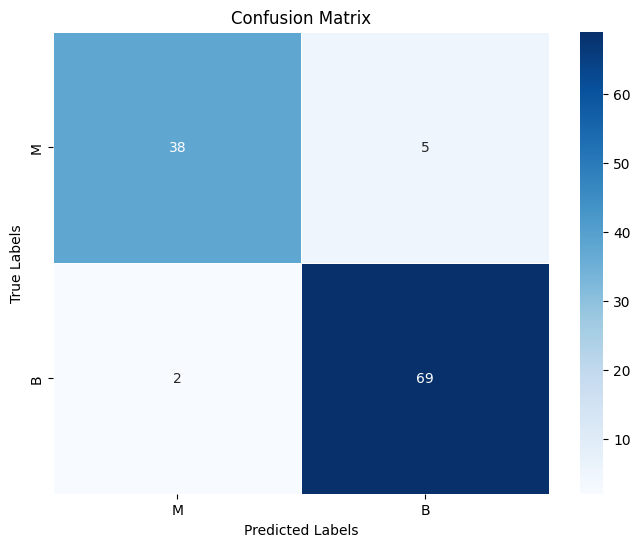

In [31]:
labels = ['M', 'B']
cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm , annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Training and testing with pruning ON

In [32]:
pruned_tree = train(X_train = X_train, y_train = y_train_mapped, criterion="gini_index", max_depth=5, significance_level = 0.05, prune = "ON")

In [33]:
y_pred_dev_pruned= pruned_tree.predict(X_dev)

In [34]:
accuracy = accuracy_score(y_dev_mapped, y_pred_dev_pruned)
print("Accuracy Obtained:", accuracy)

Accuracy Obtained: 0.9210526315789473


## Visualizing the decision tree using graphviz

In [35]:
data_train.columns

Index(['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness',
       'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension',
       'seRadius', 'seTexture', 'sePerimeter', 'seArea', 'seSmoothness',
       'seCompactness', 'seConcavity', 'seConcavePoints', 'seSymmetry',
       'seFractalDimension', 'worstRadius', 'worstTexture', 'worstPerimeter',
       'worstArea', 'worstSmoothness', 'worstCompactness', 'worstConcavity',
       'worstConcavePoints', 'worstSymmetry', 'worstFractalDimension',
       'Diagnosis'],
      dtype='object')

In [36]:
!pip install graphviz

In [37]:
from sklearn.tree import export_graphviz
import graphviz

### tree with no pruning

In [38]:
dot = tree.export_graphviz(feature_names=['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness',
       'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension',
       'seRadius', 'seTexture', 'sePerimeter', 'seArea', 'seSmoothness',
       'seCompactness', 'seConcavity', 'seConcavePoints', 'seSymmetry',
       'seFractalDimension', 'worstRadius', 'worstTexture', 'worstPerimeter',
       'worstArea', 'worstSmoothness', 'worstCompactness', 'worstConcavity',
       'worstConcavePoints', 'worstSymmetry', 'worstFractalDimension'])
dot.render('decision_tree', format='png')  # Save as a PNG image
dot.view()

'decision_tree.pdf'

### tree with pruning

In [39]:
dot_pruned = pruned_tree.export_graphviz(feature_names=['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness',
       'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension',
       'seRadius', 'seTexture', 'sePerimeter', 'seArea', 'seSmoothness',
       'seCompactness', 'seConcavity', 'seConcavePoints', 'seSymmetry',
       'seFractalDimension', 'worstRadius', 'worstTexture', 'worstPerimeter',
       'worstArea', 'worstSmoothness', 'worstCompactness', 'worstConcavity',
       'worstConcavePoints', 'worstSymmetry', 'worstFractalDimension'])
dot_pruned.render('decision_tree_pruned', format='png')  # Save as a PNG image
dot.view()

'decision_tree.pdf'

## Using different combinations of hyperparameters to find the model with best performance

In [40]:
criterion = ["gini_index", "standard_information_gain"]
max_depth_values = [None, 3, 5]
chi_square_threshold_values = None
prune_values = ["ON", "OFF"]

In [41]:
best_model = None
best_accuracy = 0
best_params = {}

criteria = gini_index, max_depth=None, significance_level=0.01, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


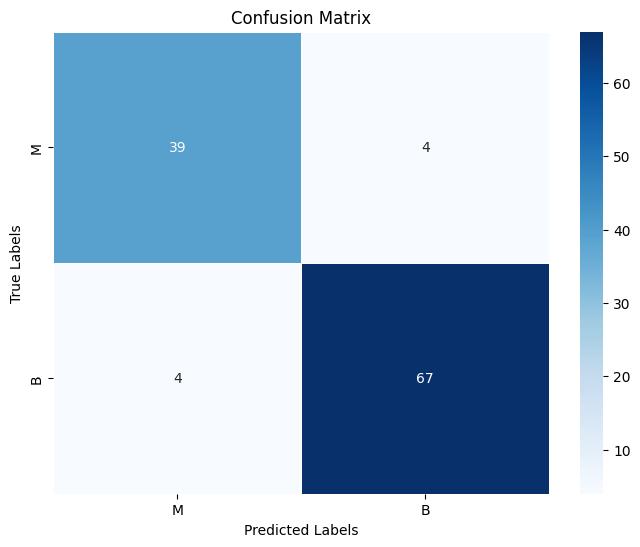

--------------------------------------------------
criteria = gini_index, max_depth=None, significance_level=0.05, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


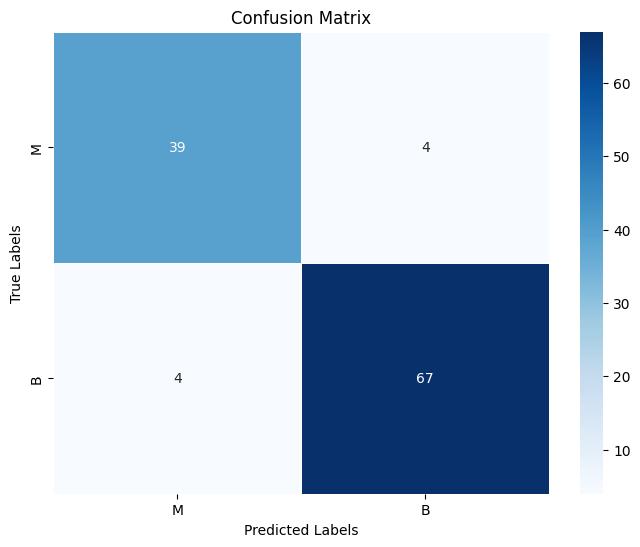

--------------------------------------------------
criteria = gini_index, max_depth=None, significance_level=0.1, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


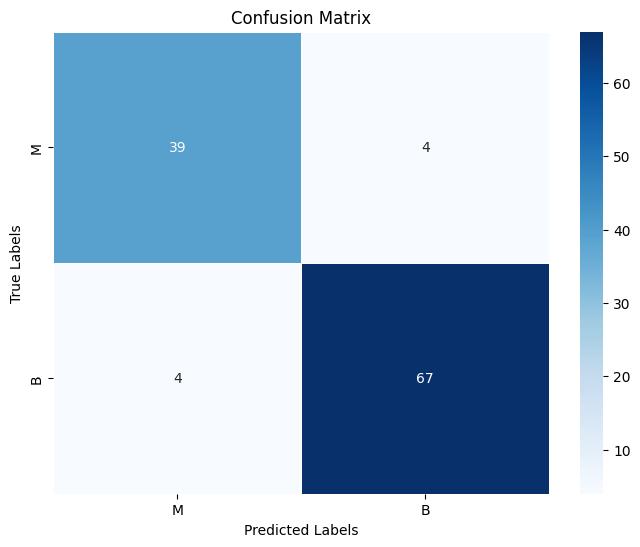

--------------------------------------------------
criteria = gini_index, max_depth=None, significance_level=0.01, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


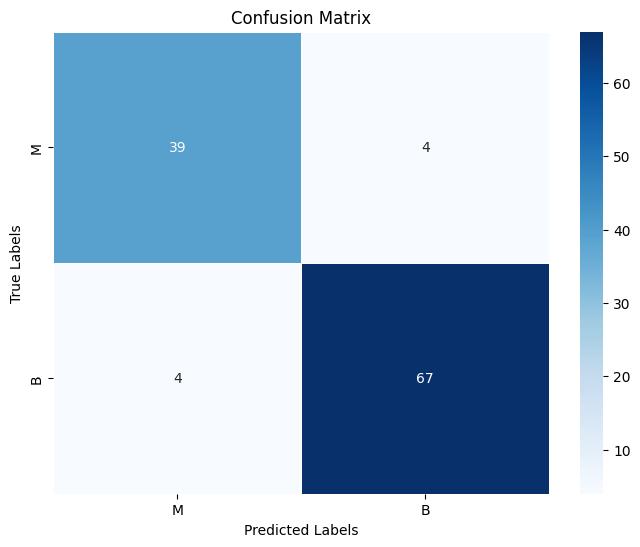

--------------------------------------------------
criteria = gini_index, max_depth=None, significance_level=0.05, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


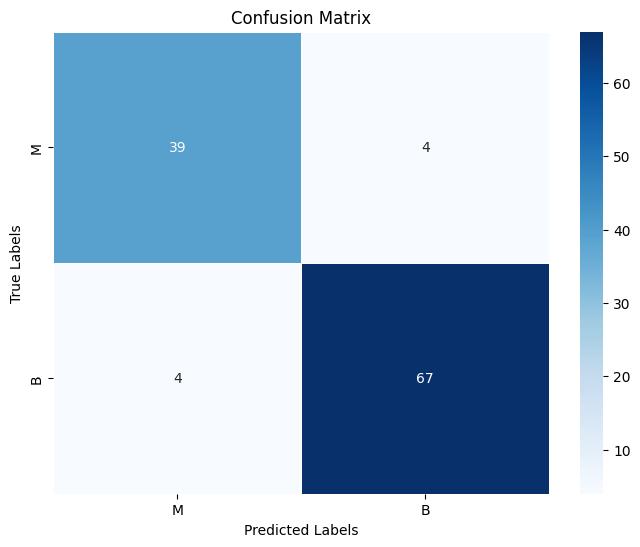

--------------------------------------------------
criteria = gini_index, max_depth=None, significance_level=0.1, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


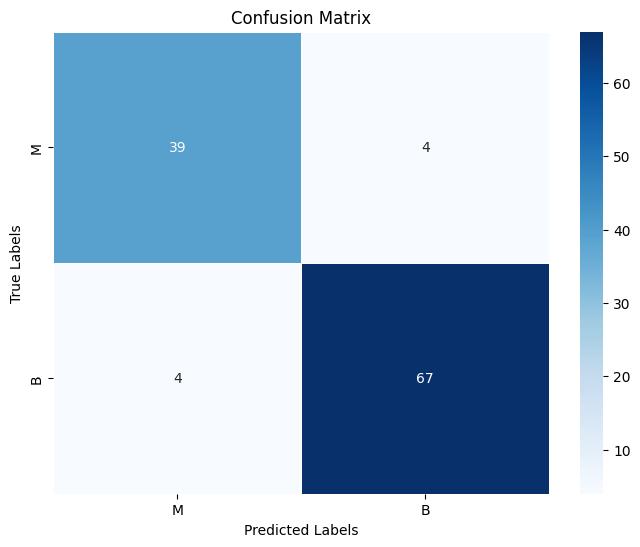

--------------------------------------------------
criteria = gini_index, max_depth=3, significance_level=0.01, prune=ON
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


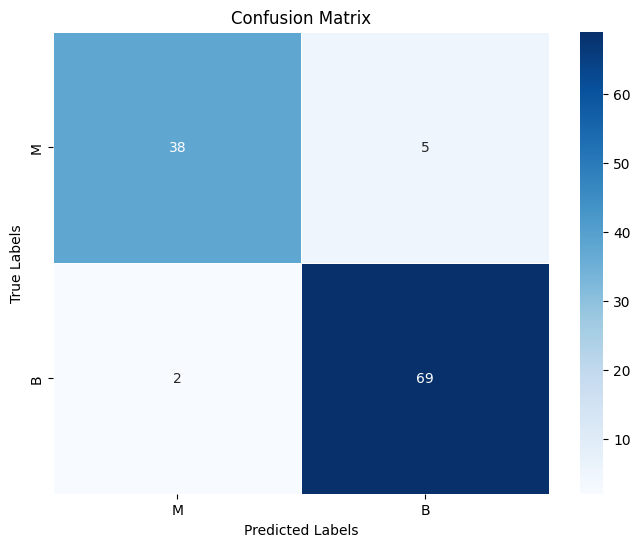

--------------------------------------------------
criteria = gini_index, max_depth=3, significance_level=0.05, prune=ON
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


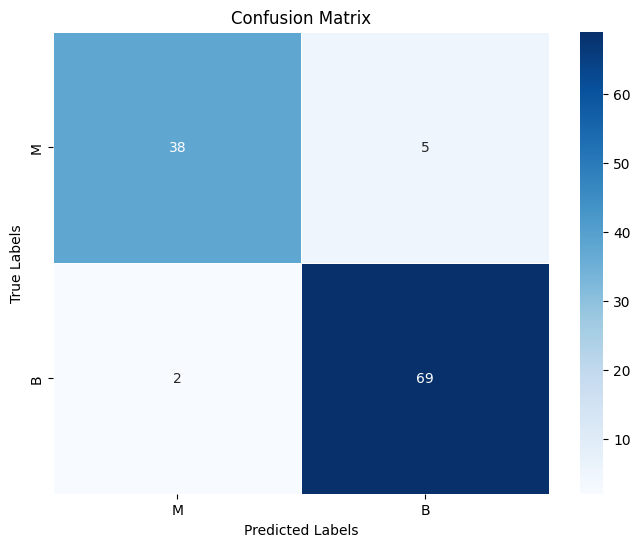

--------------------------------------------------
criteria = gini_index, max_depth=3, significance_level=0.1, prune=ON
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


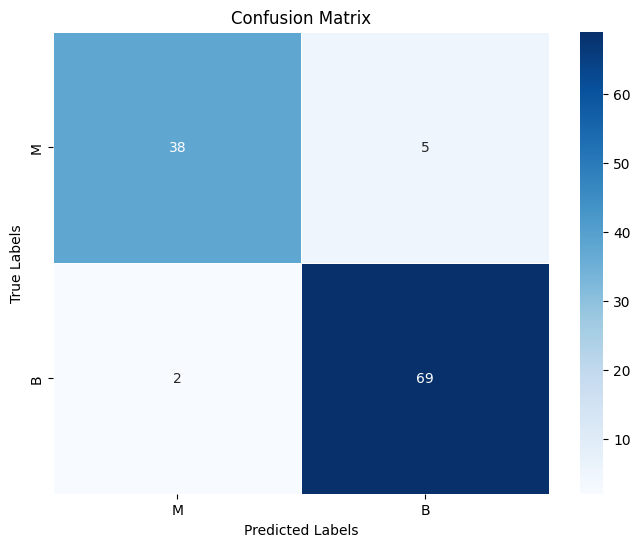

--------------------------------------------------
criteria = gini_index, max_depth=3, significance_level=0.01, prune=OFF
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


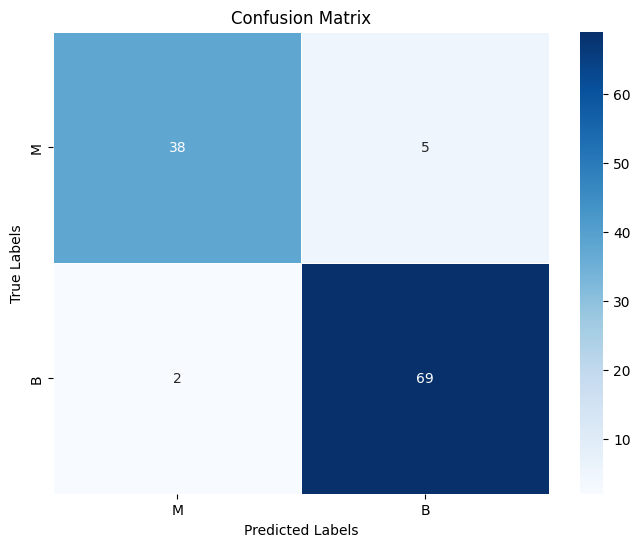

--------------------------------------------------
criteria = gini_index, max_depth=3, significance_level=0.05, prune=OFF
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


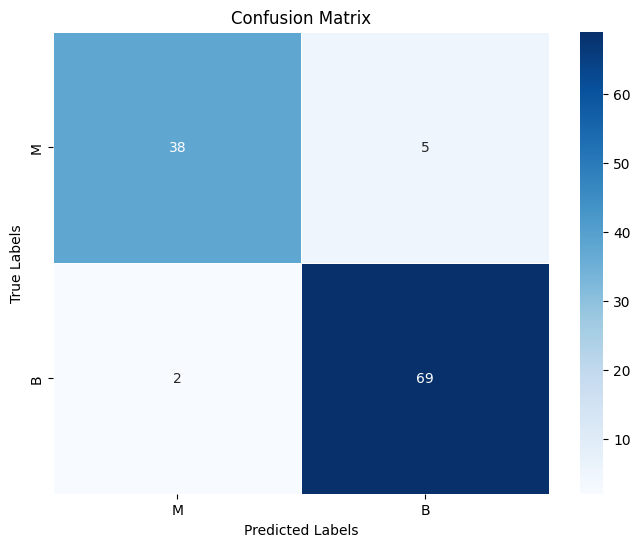

--------------------------------------------------
criteria = gini_index, max_depth=3, significance_level=0.1, prune=OFF
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


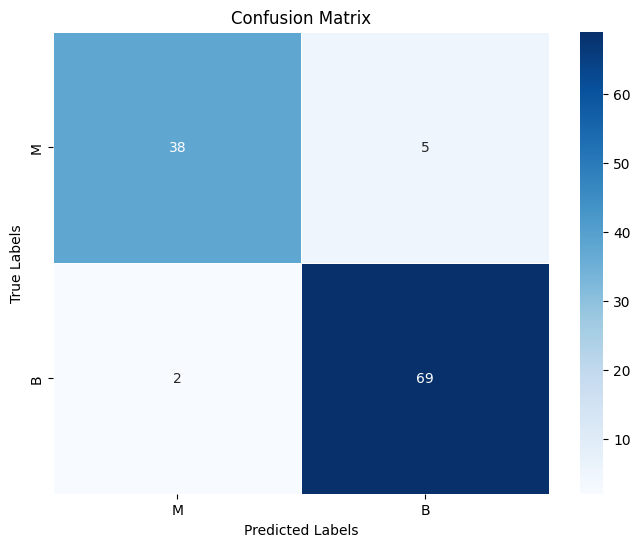

--------------------------------------------------
criteria = gini_index, max_depth=5, significance_level=0.01, prune=ON
Accuracy: 0.9211
Precision: 0.9048
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 4 67]]


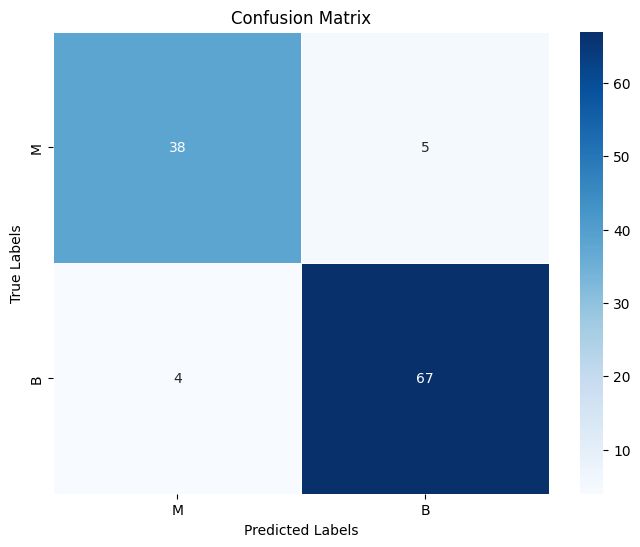

--------------------------------------------------
criteria = gini_index, max_depth=5, significance_level=0.05, prune=ON
Accuracy: 0.9211
Precision: 0.9048
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 4 67]]


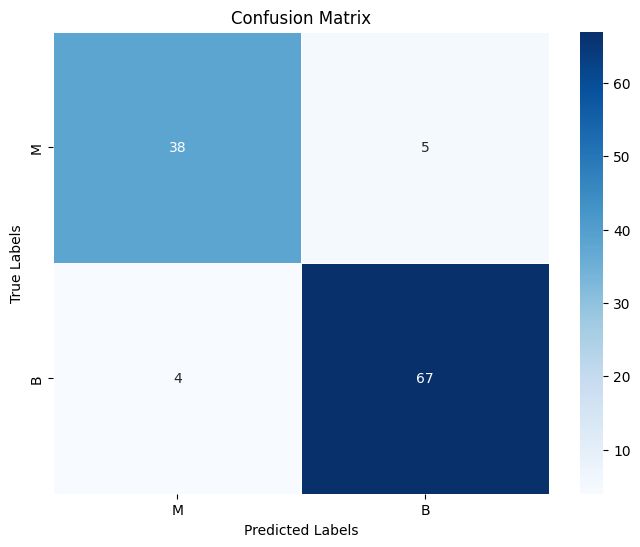

--------------------------------------------------
criteria = gini_index, max_depth=5, significance_level=0.1, prune=ON
Accuracy: 0.9211
Precision: 0.9048
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 4 67]]


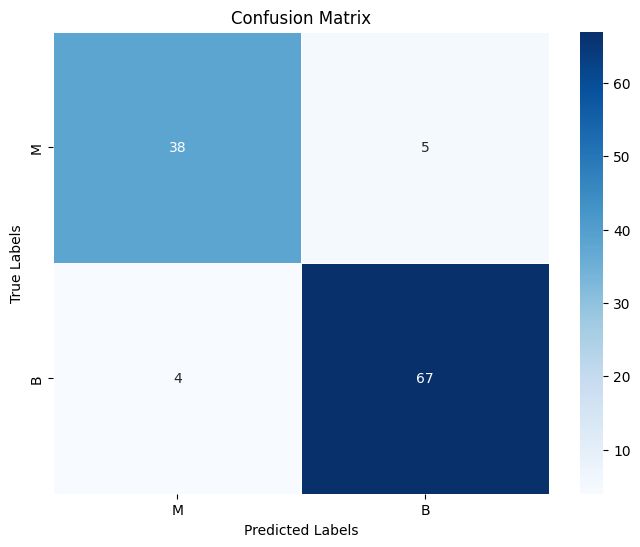

--------------------------------------------------
criteria = gini_index, max_depth=5, significance_level=0.01, prune=OFF
Accuracy: 0.9211
Precision: 0.9048
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 4 67]]


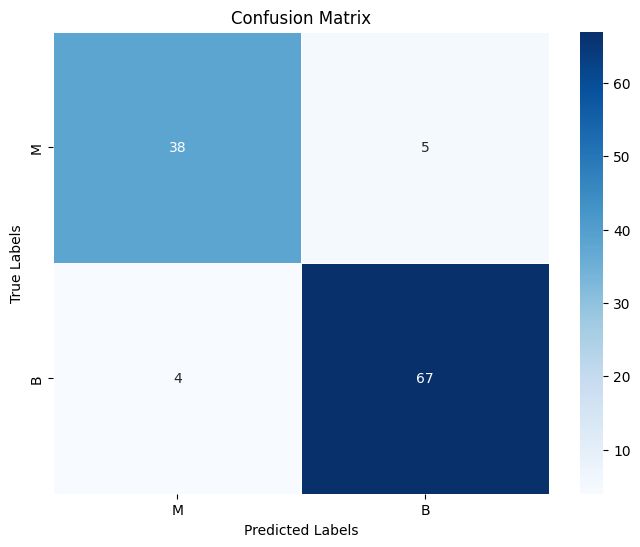

--------------------------------------------------
criteria = gini_index, max_depth=5, significance_level=0.05, prune=OFF
Accuracy: 0.9211
Precision: 0.9048
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 4 67]]


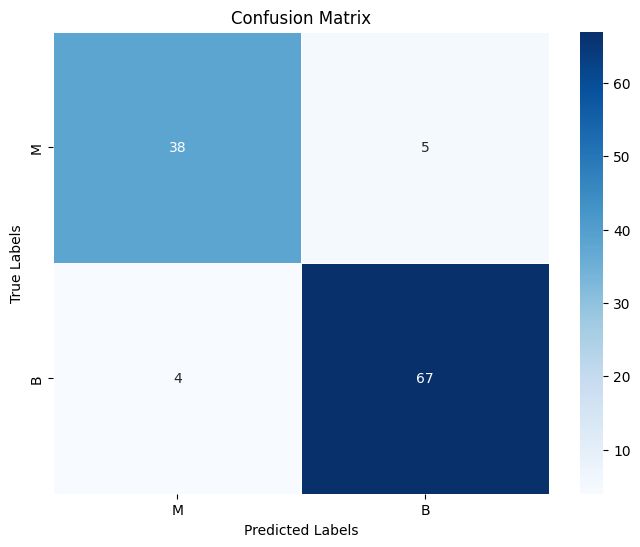

--------------------------------------------------
criteria = gini_index, max_depth=5, significance_level=0.1, prune=OFF
Accuracy: 0.9211
Precision: 0.9048
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 4 67]]


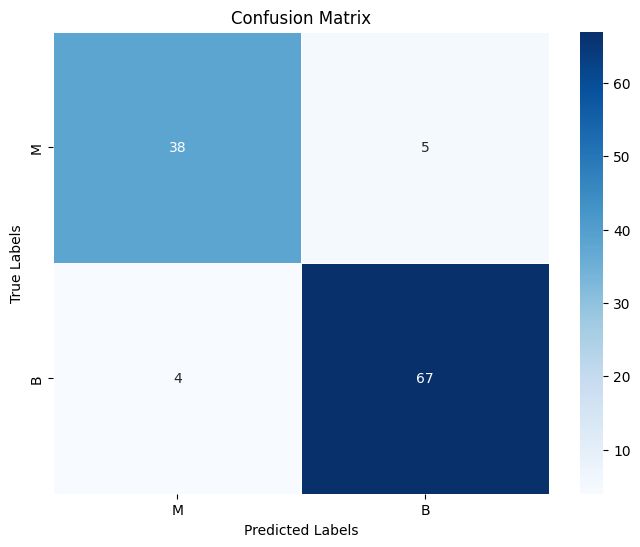

--------------------------------------------------
criteria = standard_information_gain, max_depth=None, significance_level=0.01, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


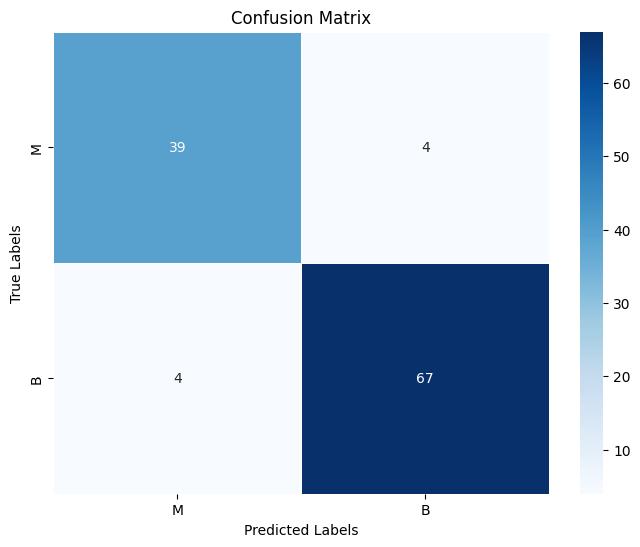

--------------------------------------------------
criteria = standard_information_gain, max_depth=None, significance_level=0.05, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


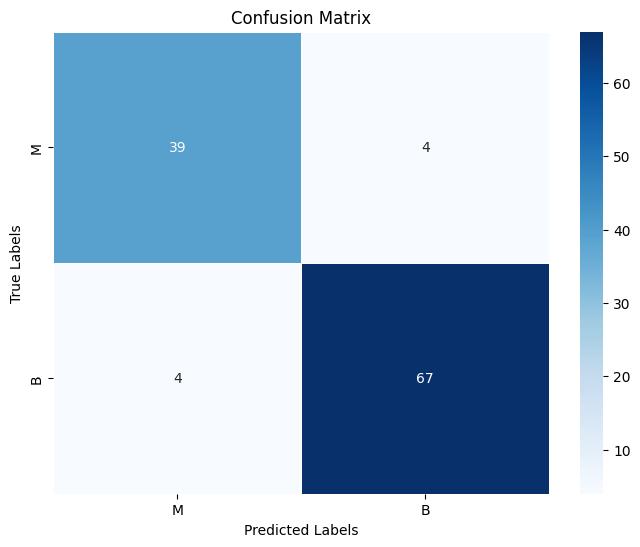

--------------------------------------------------
criteria = standard_information_gain, max_depth=None, significance_level=0.1, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


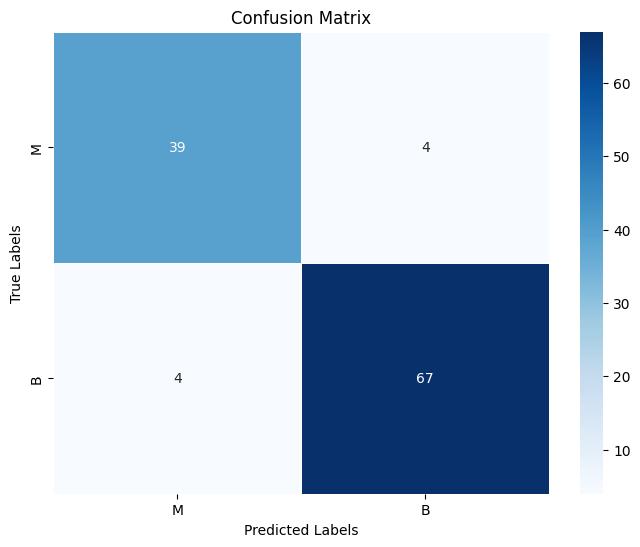

--------------------------------------------------
criteria = standard_information_gain, max_depth=None, significance_level=0.01, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


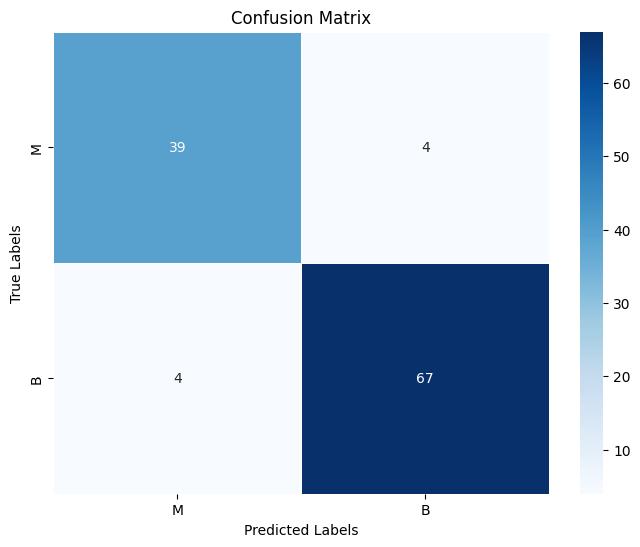

--------------------------------------------------
criteria = standard_information_gain, max_depth=None, significance_level=0.05, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


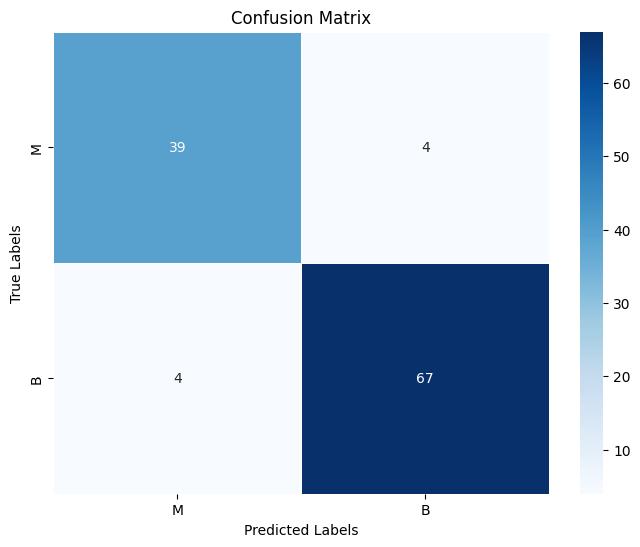

--------------------------------------------------
criteria = standard_information_gain, max_depth=None, significance_level=0.1, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


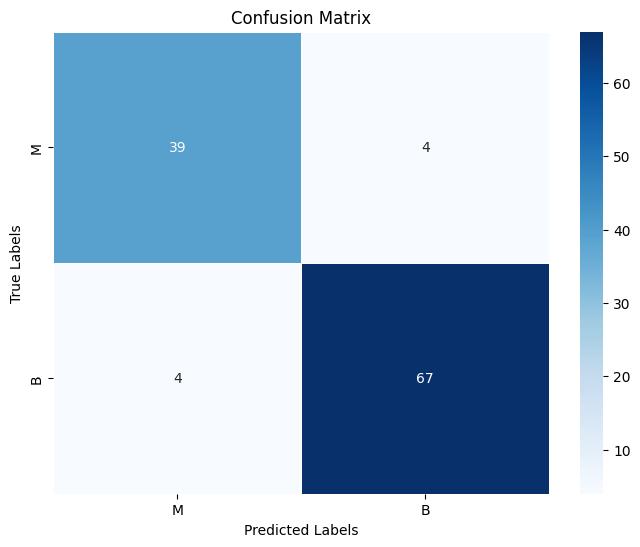

--------------------------------------------------
criteria = standard_information_gain, max_depth=3, significance_level=0.01, prune=ON
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


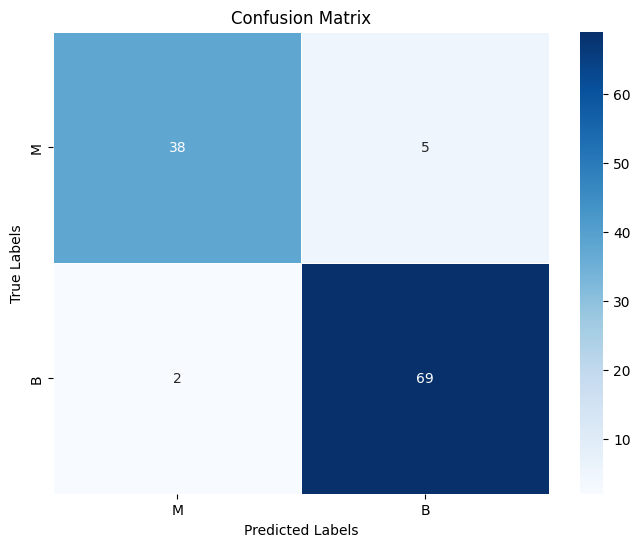

--------------------------------------------------
criteria = standard_information_gain, max_depth=3, significance_level=0.05, prune=ON
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


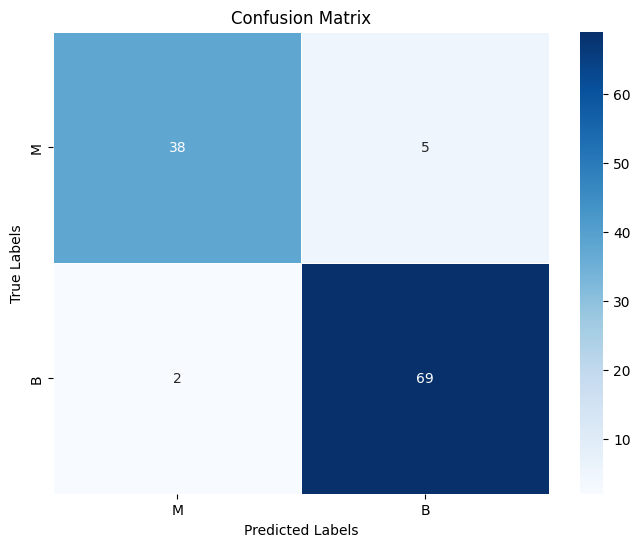

--------------------------------------------------
criteria = standard_information_gain, max_depth=3, significance_level=0.1, prune=ON
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


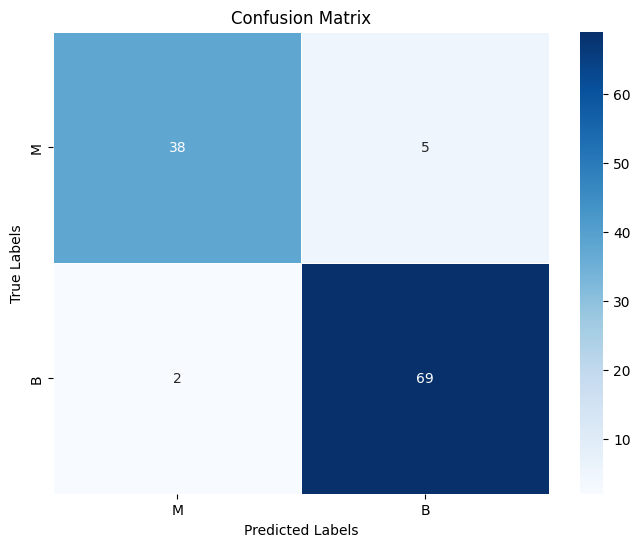

--------------------------------------------------
criteria = standard_information_gain, max_depth=3, significance_level=0.01, prune=OFF
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


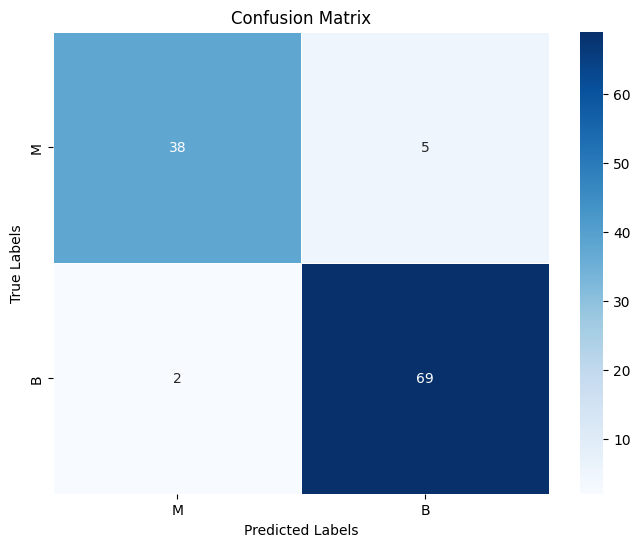

--------------------------------------------------
criteria = standard_information_gain, max_depth=3, significance_level=0.05, prune=OFF
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


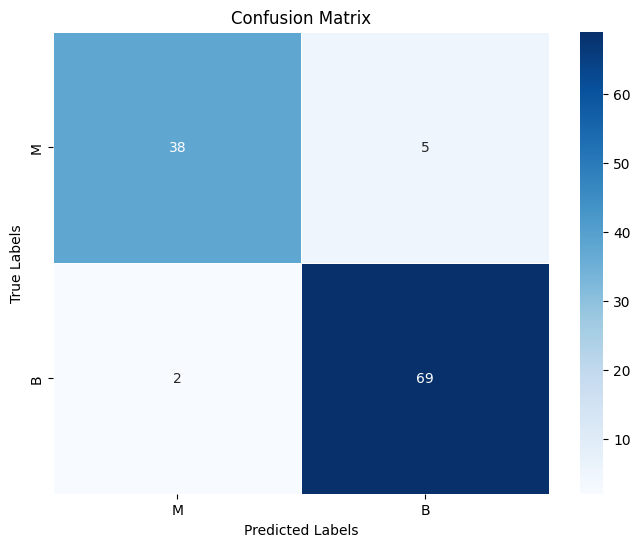

--------------------------------------------------
criteria = standard_information_gain, max_depth=3, significance_level=0.1, prune=OFF
Accuracy: 0.9386
Precision: 0.9500
Recall: 0.8837
Confusion Matrix:
[[38  5]
 [ 2 69]]


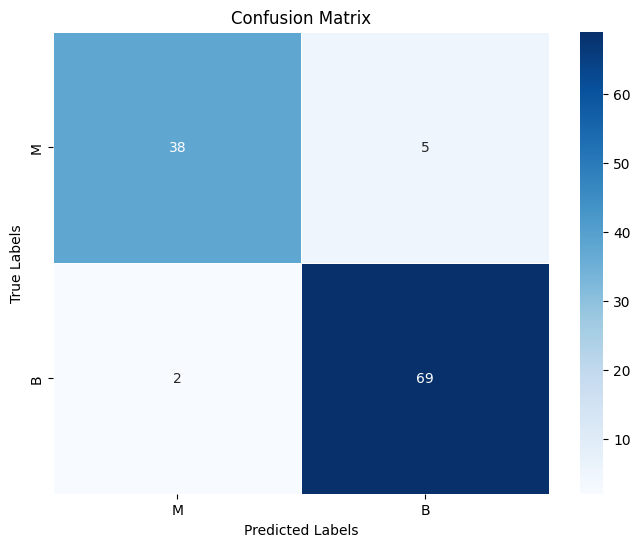

--------------------------------------------------
criteria = standard_information_gain, max_depth=5, significance_level=0.01, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


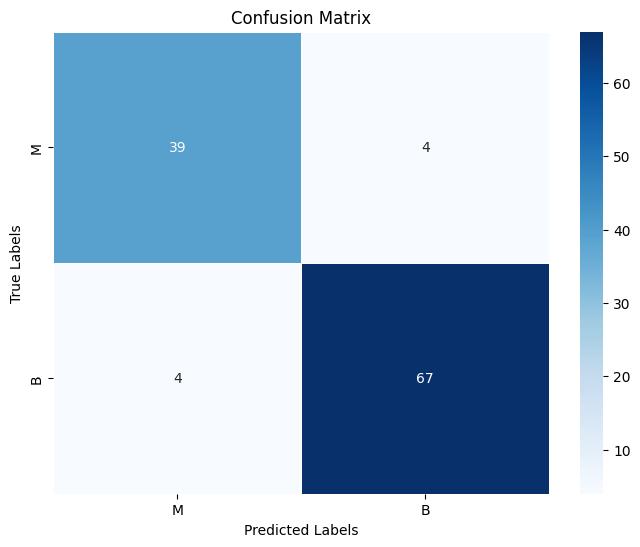

--------------------------------------------------
criteria = standard_information_gain, max_depth=5, significance_level=0.05, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


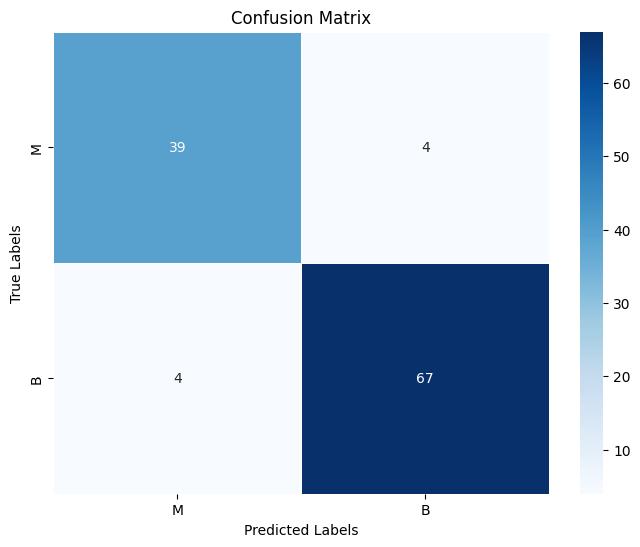

--------------------------------------------------
criteria = standard_information_gain, max_depth=5, significance_level=0.1, prune=ON
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


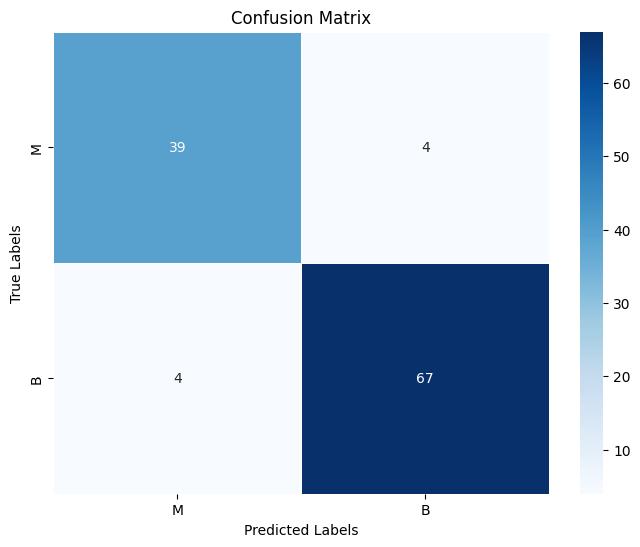

--------------------------------------------------
criteria = standard_information_gain, max_depth=5, significance_level=0.01, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


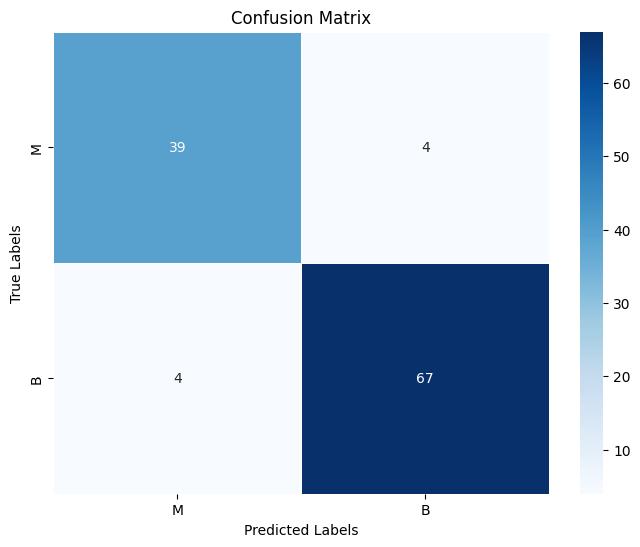

--------------------------------------------------
criteria = standard_information_gain, max_depth=5, significance_level=0.05, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


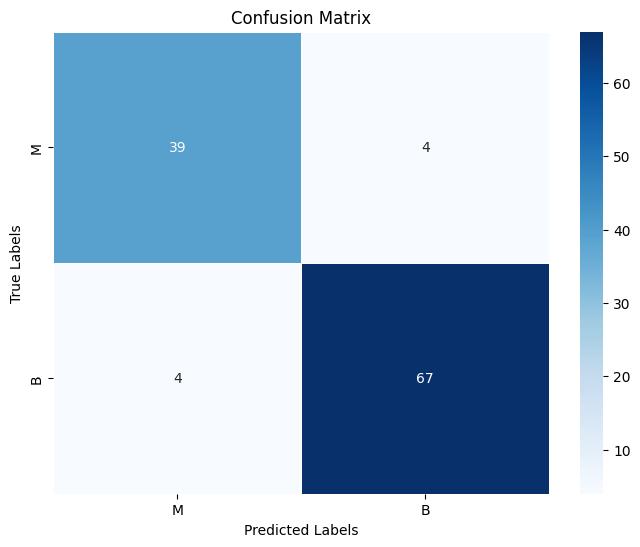

--------------------------------------------------
criteria = standard_information_gain, max_depth=5, significance_level=0.1, prune=OFF
Accuracy: 0.9298
Precision: 0.9070
Recall: 0.9070
Confusion Matrix:
[[39  4]
 [ 4 67]]


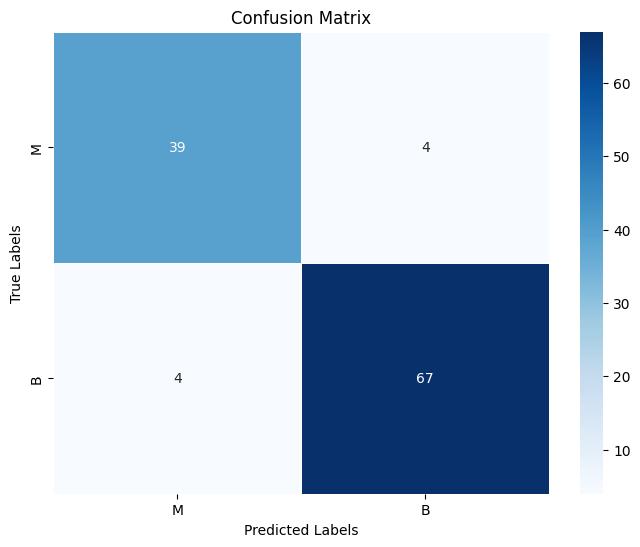

--------------------------------------------------


In [42]:
i = 0
for criteria in criterion:
    for max_depth in max_depth_values:
        for prune in prune_values:
            if prune == "ON":
                chi_square_threshold_values = [0.01, 0.05, 0.1]
            
            if chi_square_threshold_values:
            
                for significance_level in chi_square_threshold_values:
                    i = i+1
                    model = train(X_train = X_train, y_train = y_train_mapped, criterion=criteria, max_depth=max_depth, significance_level = significance_level, prune = prune)
                    dot = tree.export_graphviz(feature_names=['Radius', 'Texture', 'Perimeter', 'Area', 'Smoothness', 'Compactness', 'Concavity', 'ConcavePoints', 'Symmetry', 'FractalDimension', 'seRadius', 'seTexture', 'sePerimeter', 'seArea', 'seSmoothness','seCompactness', 'seConcavity', 'seConcavePoints', 'seSymmetry','seFractalDimension', 'worstRadius', 'worstTexture', 'worstPerimeter', 'worstArea', 'worstSmoothness', 'worstCompactness', 'worstConcavity', 'worstConcavePoints', 'worstSymmetry', 'worstFractalDimension'])
                    dot.render('decision_tree' + str(i), format='png')  # Save as a PNG image
                    y_pred = model.predict(X_dev)
                        
                    # Evaluate the model
                    accuracy = accuracy_score(y_dev_mapped, y_pred)
                    precision = precision_score(y_dev_mapped, y_pred)
                    recall = recall_score(y_dev_mapped, y_pred)
                    cm = confusion_matrix(y_dev_mapped, y_pred, labels = [1, 0])
                        
                    # Print evaluation metrics
                    print(f"criteria = {criteria}, max_depth={max_depth}, significance_level={significance_level}, prune={prune}")
                    print(f"Accuracy: {accuracy:.4f}")
                    print(f"Precision: {precision:.4f}")
                    print(f"Recall: {recall:.4f}")
                    print("Confusion Matrix:")
                    print(cm)
                    labels = ['M', 'B']
                    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
                    plt.figure(figsize=(8, 6))
                    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5)
                    plt.title('Confusion Matrix')
                    plt.xlabel('Predicted Labels')
                    plt.ylabel('True Labels')
                    plt.show()
                    print("-" * 50)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = model
                        best_params = {
                                'criteria' : criteria,
                                'max_depth': max_depth,
                                'significance_level': significance_level,
                                'prune': prune
                        }

In [43]:
print("Best Model hyperparameters:")
print(f"criteria = {criteria}, max_depth={max_depth}, significance_level={significance_level}, prune={prune}")

Best Model hyperparameters:
criteria = standard_information_gain, max_depth=5, significance_level=0.1, prune=OFF


## Majority Class classifier

In [44]:
# definr majority class classifier which returns  most frequent class for every instance
class MajorityClassClassifier:
    
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, y_train_mapped):
        classes, counts = np.unique(y_train_mapped, return_counts=True)
        most_frequent_index = np.argmax(counts)
        self.most_frequent_class = classes[most_frequent_index]

    def predict(self, X_test):
        # Return an array with the most frequent class for every test instance
        return np.full(X_test.shape[0], self.most_frequent_class)

In [45]:
# create an object of majority class classifier
majority_classifier = MajorityClassClassifier()
majority_classifier.fit(y_train_mapped)
y_pred_majority = majority_classifier.predict(X_test)

In [46]:
y_pred_majority

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [47]:
accuracy_freq_class = accuracy_score(y_test_mapped, y_pred_majority)
print("Accuracy for the majority class classifier:", accuracy_freq_class)
error_freq_class = 1 - accuracy_freq_class
print("Error for the majority class classifier:", error_freq_class)
precision_freq_class = accuracy_score(y_test_mapped, y_pred_majority)
print("Precision for the majority class classifier:", precision_freq_class)
recall_freq_class = accuracy_score(y_test_mapped, y_pred_majority)
print("Recall for the majority class classifier:", recall_freq_class)

Accuracy for the majority class classifier: 0.631578947368421
Error for the majority class classifier: 0.368421052631579
Precision for the majority class classifier: 0.631578947368421
Recall for the majority class classifier: 0.631578947368421


## Testing using test data, the best decision tree model

In [48]:
# Test the best model using test data and find the accuracy
if best_model:
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test_mapped, y_test_pred)
    test_error = 1 - test_accuracy
    test_precision = precision_score(y_test_mapped, y_test_pred)
    test_recall = recall_score(y_test_mapped, y_test_pred)
    test_cm = confusion_matrix(y_test_mapped, y_test_pred, labels = [0,1])
    
    print("Best Model Performance on Test datset:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Error: {test_error:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print("Test Confusion Matrix:")
    print(test_cm)

Best Model Performance on Test datset:
Test Accuracy: 0.9386
Test Error: 0.0614
Test Precision: 1.0000
Test Recall: 0.8333
Test Confusion Matrix:
[[72  0]
 [ 7 35]]


## Discretization Process using equal_frequency binning or quantile binning

In [49]:
data_test_raw = pd.read_csv('wdbc_test_raw.csv')
data_test_raw = data_test_raw.drop('Diagnosis', axis = 1)
data_test_raw

,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,ConcavePoints,Symmetry,FractalDimension,...,worstRadius,worstTexture,worstPerimeter,worstArea,worstSmoothness,worstCompactness,worstConcavity,worstConcavePoints,worstSymmetry,worstFractalDimension
0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.16250,0.2364,0.07678
1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,17.060,28.14,110.60,897.0,0.16540,0.36820,0.2678,0.15560,0.3196,0.11510
2,19.17,24.80,132.40,1123.0,0.09740,0.24580,0.20650,0.11180,0.2397,0.07800,...,20.960,29.94,151.70,1332.0,0.10370,0.39030,0.3639,0.17670,0.3176,0.10230
3,14.54,27.54,96.73,658.8,0.11390,0.15950,0.16390,0.07364,0.2303,0.07077,...,17.460,37.13,124.10,943.2,0.16780,0.65770,0.7026,0.17120,0.4218,0.13410
4,13.08,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,0.06811,...,14.500,20.49,96.09,630.5,0.13120,0.27760,0.1890,0.07283,0.3184,0.08183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,12.88,28.92,82.50,514.3,0.08123,0.05824,0.06195,0.02343,0.1566,0.05708,...,13.890,35.74,88.84,595.7,0.12270,0.16200,0.2439,0.06493,0.2372,0.07242
110,10.29,27.61,65.67,321.4,0.09030,0.07658,0.05999,0.02738,0.1593,0.06127,...,10.840,34.91,69.57,357.6,0.13840,0.17100,0.2000,0.09127,0.2226,0.08283
111,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.300,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321
112,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,...,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090


In [50]:
features = data_test_raw.columns  
n_bins = 6
labels = ['l1', 'l2', 'l3', 'l4', 'l5', 'l6']

In [51]:
# Apply equal-frequency binning (quantile binning) to each feature
for feature in features:
    data_test_raw[feature + '_discretized'] = pd.qcut(data_test_raw[feature], q=n_bins, labels=labels)
print(data_test_raw.head())

   Radius  Texture  Perimeter    Area  Smoothness  Compactness  Concavity  \
0   20.29    14.34     135.10  1297.0      0.1003       0.1328    0.19800   
1   13.71    20.83      90.20   577.9      0.1189       0.1645    0.09366   
2   19.17    24.80     132.40  1123.0      0.0974       0.2458    0.20650   
3   14.54    27.54      96.73   658.8      0.1139       0.1595    0.16390   
4   13.08    15.71      85.63   520.0      0.1075       0.1270    0.04568   

   ConcavePoints  Symmetry  FractalDimension  ...  worstRadius_discretized  \
0        0.10430    0.1809           0.05883  ...                       l6   
1        0.05985    0.2196           0.07451  ...                       l5   
2        0.11180    0.2397           0.07800  ...                       l6   
3        0.07364    0.2303           0.07077  ...                       l5   
4        0.03110    0.1967           0.06811  ...                       l3   

   worstTexture_discretized  worstPerimeter_discretized  \
0        

## Problem 4: Compare with an implementation in an ML library

### Q13: compare and contrast the performance of the binned versus non-binned (normalized)data and report if there is a difference in performance between the two

In [52]:
# read the binned data
data_train_binned = pd.read_csv('wdbc_train.csv')
data_dev_binned = pd.read_csv('wdbc_dev.csv')
data_test_binned = pd.read_csv('wdbc_test.csv')

In [53]:
data_train_binned

,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,ConcavePoints,Symmetry,FractalDimension,...,worstTexture,worstPerimeter,worstArea,worstSmoothness,worstCompactness,worstConcavity,worstConcavePoints,worstSymmetry,worstFractalDimension,Diagnosis
0,l4,l5,l4,l4,l5,l4,l4,l5,l4,l4,...,l5,l4,l4,l5,l4,l4,l4,l4,l4,M
1,l2,l3,l2,l2,l3,l3,l3,l3,l5,l4,...,l3,l2,l3,l3,l3,l3,l3,l4,l4,B
2,l4,l3,l4,l4,l3,l3,l3,l3,l2,l2,...,l3,l3,l3,l3,l3,l3,l3,l3,l3,B
3,l5,l4,l5,l5,l4,l4,l5,l5,l4,l3,...,l4,l5,l4,l3,l3,l4,l5,l3,l3,M
4,l3,l6,l3,l3,l2,l2,l2,l2,l3,l3,...,l6,l3,l3,l2,l2,l2,l2,l3,l3,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,l2,l3,l2,l2,l2,l2,l2,l2,l3,l4,...,l3,l2,l2,l1,l2,l2,l2,l2,l2,B
337,l3,l3,l3,l3,l3,l2,l3,l3,l2,l3,...,l3,l3,l3,l2,l2,l2,l3,l2,l2,B
338,l3,l4,l3,l3,l4,l3,l3,l3,l4,l4,...,l4,l3,l3,l4,l3,l3,l3,l4,l3,B
339,l3,l5,l3,l3,l3,l2,l3,l3,l3,l2,...,l5,l3,l3,l3,l3,l2,l3,l3,l2,B


In [54]:
X_train_binned = data_train_binned.iloc[:, :-1].values  # Features
y_train_binned = data_train_binned.iloc[:, -1].values   # Target

X_dev_binned = data_dev_binned.iloc[:, :-1].values      # Dev features
y_dev_binned = data_dev_binned.iloc[:, -1].values       # Dev target

X_test_binned = data_test_binned.iloc[:, :-1].values    # Test features
y_test_binned = data_test_binned.iloc[:, -1].values     # Test target

In [55]:
X_train_binned

array([['l4', 'l5', 'l4', ..., 'l4', 'l4', 'l4'],
       ['l2', 'l3', 'l2', ..., 'l3', 'l4', 'l4'],
       ['l4', 'l3', 'l4', ..., 'l3', 'l3', 'l3'],
       ...,
       ['l3', 'l4', 'l3', ..., 'l3', 'l4', 'l3'],
       ['l3', 'l5', 'l3', ..., 'l3', 'l3', 'l2'],
       ['l4', 'l4', 'l4', ..., 'l4', 'l3', 'l3']], dtype=object)

In [56]:
# Here M- Malignant is considered positive and Bening is considered negative, so I map M-1, B-0
y_train_mapped = np.where(y_train_binned == 'B', 0, 1)
y_test_mapped = np.where(y_test_binned == 'B', 0, 1)
y_dev_mapped = np.where(y_dev_binned == 'B', 0, 1)

In [57]:
# train the decision tree model with the binned data
model = train(X_train = X_train_binned, y_train = y_train_mapped, criterion="standard_information_gain", max_depth=3, significance_level = 0.1, prune = "OFF")

In [58]:
# predict for the dev data
y_pred_binned = model.predict(X_dev_binned)

In [59]:
y_pred_binned

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(1),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(1),
 np.int64(0),
 np.int64(0),
 np.in

In [60]:
accuracy = accuracy_score(y_dev_mapped, y_pred_binned)
print("Accuracy Obtained:", accuracy)

Accuracy Obtained: 0.9736842105263158


In [61]:
precision = precision_score(y_dev_mapped, y_pred_binned)
print("Precision Obtained:", precision)

Precision Obtained: 1.0


In [62]:
recall = recall_score(y_dev_mapped, y_pred_binned)
print("Recall Obtained:", recall)

Recall Obtained: 0.9302325581395349


In [63]:
# predict for the test data
test_pred_binned = model.predict(X_test_binned)

In [64]:
accuracy = accuracy_score(y_dev_mapped, test_pred_binned)
print("Accuracy Obtained:", accuracy)

Accuracy Obtained: 0.5877192982456141
